<a href="https://colab.research.google.com/github/Luanmantegazine/FedAlzheimer/blob/main/FlowerFL_(FedAvgM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install -U "flwr[simulation]"
!pip install torch torchvision scikit-learn matplotlib torchmetrics

In [15]:
import random
import os
from collections import Counter, OrderedDict
from contextlib import nullcontext
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights

import flwr as fl
from flwr.client import ClientApp
from flwr.server import ServerApp, ServerAppComponents, ServerConfig
from flwr.common import NDArrays, ndarrays_to_parameters, Context
from flwr.server.strategy import FedAvgM
from flwr.simulation import run_simulation

import torchmetrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [16]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ.pop("NVIDIA_VISIBLE_DEVICES", None)
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

Utils

In [17]:
class Config:

  data_path: str = "/content/drive/MyDrive/TCC - Grupo SLD/Projeto 2/ADNI"

  num_clients = 3
  num_rounds = 10
  seed = 1234

  partition_strategy = "dirichlet"
  dirichlet_alpha = 0.5
  shards_per_clients = 2

  batch_size = 32
  local_epochs = 1
  learning_rate = 1e-4

  server_learning_rate = 0.001
  server_momentum = 0.9

config = Config()


In [18]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device() -> torch.device:
    return torch.device("cpu")

def build_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return train_transform, test_transform

def partition_iid(indices: np.ndarray, num_clients: int):
    splits = np.array_split(indices, num_clients)
    return {cid: split for cid, split in enumerate(splits)}

def partition_dirichlet(labels_all: List[int], idxs: np.ndarray, num_clients: int, alpha: float, seed: int, min_size: int = 10):
    rng = np.random.RandomState(seed)
    labels = np.array([labels_all[i] for i in idxs])
    client_indices = {i: [] for i in range(num_clients)}
    min_client_size = 0
    while min_client_size < min_size:
        client_indices = {i: [] for i in range(num_clients)}
        for c in np.unique(labels):
            idx_c = idxs[labels == c]
            rng.shuffle(idx_c)
            proportions = rng.dirichlet(alpha=np.repeat(alpha, num_clients))
            proportions /= proportions.sum()
            splits = (np.cumsum(proportions) * len(idx_c)).astype(int)[:-1]
            chunks = np.split(idx_c, splits)
            for i, chunk in enumerate(chunks):
                client_indices[i].extend(chunk.tolist())
        sizes = [len(client_indices[i]) for i in range(num_clients)]
        if not sizes or min(sizes) == 0:
            min_client_size = 0
            continue
        min_client_size = min(sizes)
    return {i: np.array(v) for i, v in client_indices.items()}

def partition_shards(labels_all: List[int], idxs: np.ndarray, num_clients: int, shards_per_client: int, seed: int):
    rng = np.random.RandomState(seed)
    labels = np.array([labels_all[i] for i in idxs])
    sorted_order = np.argsort(labels)
    sorted_idxs = idxs[sorted_order]
    num_shards = num_clients * shards_per_client
    shard_size = int(np.ceil(len(sorted_idxs) / num_shards))
    shards = [sorted_idxs[i * shard_size:(i + 1) * shard_size] for i in range(num_shards)]
    rng.shuffle(shards)
    client_indices = {i: np.concatenate(shards[i * shards_per_client:(i + 1) * shards_per_client]) for i in range(num_clients)}
    return client_indices

def make_weights_for_balanced_classes(indices: List[int], imagefolder: datasets.ImageFolder, num_classes: int):
    labels = [imagefolder.samples[i][1] for i in indices]
    cnt = Counter(labels)
    class_weight = {c: len(labels) / (num_classes * cnt[c]) if cnt[c] > 0 else 0 for c in range(num_classes)}
    sample_weights = [class_weight[lbl] for lbl in labels]
    return torch.DoubleTensor(sample_weights)

def build_model(num_classes: int):
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(nn.Dropout(p=0.3), nn.Linear(in_features, num_classes))
    return model

def get_params(model: nn.Module):
    return [v.detach().cpu().numpy() for _, v in model.state_dict().items()]

def set_params(model: nn.Module, params: NDArrays):
    state_dict = model.state_dict()
    new_state_dict = OrderedDict({k: torch.tensor(v) for k, v in zip(state_dict.keys(), params)})
    model.load_state_dict(new_state_dict, strict=True)


In [19]:
@dataclass
class Metrics:
    loss: float
    accuracy: float
    precision: float
    recall: float
    f1: float
    auc: float

def evaluate_model(model: nn.Module, loader: DataLoader, device: torch.device, num_classes: int) -> Metrics:
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses, all_logits, all_labels = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            losses.append(criterion(logits, y).item())
            all_logits.append(logits.cpu())
            all_labels.append(y.cpu())
    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)
    preds = logits.argmax(dim=1)
    prob = F.softmax(logits, dim=1)

    try:
        auc_score = torchmetrics.functional.auroc(prob, labels, task="multiclass", num_classes=num_classes).item()
    except ValueError:
        auc_score = 0.0

    return Metrics(
        loss=float(np.mean(losses)),
        accuracy=torchmetrics.functional.accuracy(preds, labels, task="multiclass", num_classes=num_classes).item(),
        precision=torchmetrics.functional.precision(preds, labels, average="macro", task="multiclass", num_classes=num_classes, zero_division=0).item(),
        recall=torchmetrics.functional.recall(preds, labels, average="macro", task="multiclass", num_classes=num_classes, zero_division=0).item(),
        f1=torchmetrics.functional.f1_score(preds, labels, average="macro", task="multiclass", num_classes=num_classes, zero_division=0).item(),
        auc=auc_score,
    )

def weighted_average(metrics: List[Tuple[int, Dict[str, float]]]):
  total_examples = sum(n for n, _ in metrics)
  if total_examples == 0: return {}
  metric_keys = metrics[0][1].keys()
  return {k: sum(n * m.get(k, 0.0) for n, m in metrics) / total_examples for k in metric_keys}


class TransformingSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset, self.transform = subset, transform
    def __len__(self): return len(self.subset)
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform: x = self.transform(x)
        return x, y


In [20]:
class AlzheimerClient(fl.client.NumPyClient):
    def __init__(self, cid, full_dataset, train_idx, test_idx, num_classes, lr, batch_size, local_epochs, device):
        self.cid = cid
        self.num_classes = num_classes
        self.device = device
        self.model = build_model(num_classes).to(device)
        self.lr = lr
        self.local_epochs = local_epochs
        self.batch_size = batch_size
        self.use_cuda = False

        train_tf, test_tf = build_transforms()
        sub_train = TransformingSubset(Subset(full_dataset, train_idx), train_tf)
        sub_test  = TransformingSubset(Subset(full_dataset, test_idx),  test_tf)

        sampler = None
        if isinstance(full_dataset, datasets.ImageFolder) and len(train_idx) > 0:
            weights = make_weights_for_balanced_classes(train_idx, full_dataset, num_classes)
            sampler = WeightedRandomSampler(weights, num_samples=len(train_idx), replacement=True)

        self.train_loader = DataLoader(sub_train, batch_size=batch_size, shuffle=(sampler is None),
                                       sampler=sampler, num_workers=0, persistent_workers=False, pin_memory=False)
        self.test_loader  = DataLoader(sub_test,  batch_size=batch_size, shuffle=False, num_workers=0,
                                       persistent_workers=False, pin_memory=False)
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.05).to(device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-4)
        self.model = build_model(num_classes).to(self.device)
        self.scaler = torch.cuda.amp.GradScaler(enabled=False)

    def get_parameters(self, config=None):
        return get_params(self.model)

    def fit(self, parameters, config_fit):
        set_params(self.model, parameters)
        epochs = int(config_fit.get("local_epochs", self.local_epochs)) if config_fit else self.local_epochs
        self.model.train()

        amp_ctx = nullcontext()

        for _ in range(epochs):
          for x, y in self.train_loader:
              x, y = x.to(self.device), y.to(self.device)
              self.optimizer.zero_grad(set_to_none=True)
              with amp_ctx:
                  loss = self.criterion(self.model(x), y)
              loss.backward()
              self.optimizer.step()

        m = evaluate_model(self.model, self.test_loader, self.device, self.num_classes)
        return get_params(self.model), len(self.train_loader.dataset), {
            "accuracy_local": m.accuracy, "f1_local": m.f1
        }
    def evaluate(self, parameters, config_eval):
        set_params(self.model, parameters)
        m = evaluate_model(self.model, self.test_loader, self.device, self.num_classes)
        return m.loss, len(self.test_loader.dataset), {"accuracy": m.accuracy, "f1": m.f1}


In [21]:
seed_everything(config.seed)
device = get_device()
print(f"Usando dispositivo: {device}")


full_dataset = datasets.ImageFolder(root=config.data_path)
labels_all = [lbl for _, lbl in full_dataset.samples]
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes
print(f"Dataset carregado com sucesso. Encontradas {len(labels_all)} imagens em {num_classes} classes.")
print(f"Classes: {class_names}")

idx_train, idx_test = train_test_split(
    np.arange(len(full_dataset)),
    test_size=0.2,
    stratify=labels_all,
    random_state=config.seed
)

def make_partitions():
  if config.partition_strategy == "iid":
    parts_train = partition_iid(idx_train, config.num_clients)
  if config.partition_strategy == "dirichlet":
    parts_train = partition_dirichlet(labels_all, idx_train, config.num_clients, config.dirichlet_alpha, config.seed)
  return partition_dirichlet(labels_all, idx_train, config.num_clients, config.dirichlet_alpha, config.seed)

parts_train = make_partitions()

Usando dispositivo: cpu
Dataset carregado com sucesso. Encontradas 545 imagens em 3 classes.
Classes: ['AD', 'CN', 'MCI']


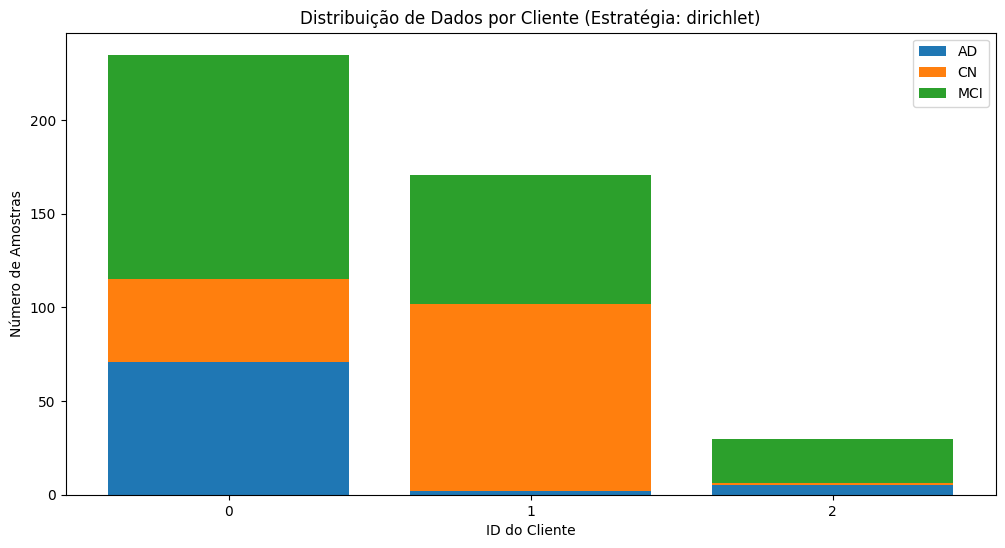

In [22]:
def plot_data_distribution(partitions: Dict[int, np.ndarray], all_labels: List[int], class_names: List[str]):

    num_clients = len(partitions)
    fig, ax = plt.subplots(figsize=(12, 6))

    client_distributions = []
    for cid in range(num_clients):
        client_labels = [all_labels[i] for i in partitions[cid]]
        class_counts = Counter(client_labels)
        client_distributions.append([class_counts.get(i, 0) for i in range(len(class_names))])

    client_distributions = np.array(client_distributions)
    bottom = np.zeros(num_clients)

    for i, class_name in enumerate(class_names):
        ax.bar(range(num_clients), client_distributions[:, i], bottom=bottom, label=class_name)
        bottom += client_distributions[:, i]

    ax.set_title(f"Distribuição de Dados por Cliente (Estratégia: {config.partition_strategy})")
    ax.set_xlabel("ID do Cliente")
    ax.set_ylabel("Número de Amostras")
    ax.set_xticks(range(num_clients))
    ax.legend()
    plt.show()
if 'parts_train' in locals() and parts_train is not None:
    plot_data_distribution(parts_train, labels_all, class_names)

In [23]:
def client_fn(context: Context):
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    cid = int(context.node_id)% config.num_clients
    client_id = int(cid)
    train_idx = parts_train[client_id]
    device = torch.device("cpu")

    return AlzheimerClient(
        cid=cid,
        full_dataset=full_dataset,
        train_idx=train_idx,
        test_idx=idx_test,
        num_classes=num_classes,
        lr=config.learning_rate,
        batch_size=config.batch_size,
        local_epochs=config.local_epochs,
        device=device
    ).to_client()

client_app = ClientApp(client_fn)

def get_evaluate_fn():
    _, test_tf = build_transforms()
    test_dataset = TransformingSubset(Subset(full_dataset, idx_test), test_tf)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False,
                             num_workers=0, persistent_workers=False, pin_memory=False)
    def evaluate(server_round: int, parameters: NDArrays, _config: Dict[str, float]):
        device = torch.device("cpu")
        model = build_model(num_classes).to(device)
        set_params(model, parameters)
        m = evaluate_model(model, test_loader, device, num_classes)
        return m.loss, {"accuracy": m.accuracy, "precision": m.precision, "recall": m.recall, "f1": m.f1, "auc": m.auc}
    return evaluate

def server_fn(context: Context) -> ServerAppComponents:
    initial_parameters = ndarrays_to_parameters(get_params(build_model(num_classes)))
    strategy = FedAvgM(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=config.num_clients,
        min_evaluate_clients=config.num_clients,
        min_available_clients=config.num_clients,
        evaluate_fn=get_evaluate_fn(),
        on_fit_config_fn=lambda r: {"local_epochs": config.local_epochs},
        evaluate_metrics_aggregation_fn=weighted_average,
        server_learning_rate=config.server_learning_rate,
        server_momentum=config.server_momentum,
        initial_parameters=initial_parameters,
    )
    return ServerAppComponents(
        strategy=strategy,
        config=ServerConfig(num_rounds=config.num_rounds),
    )

server_app = ServerApp(server_fn=server_fn)
print("Apps prontos. Iniciando simulação...")

history = run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=config.num_clients,
    backend_config={"client_resources": {"num_cpus": 1, "num_gpus": 0.0}},
)

print("Simulação concluída.")


Apps prontos. Iniciando simulação...


INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/_functional_pil.py:344: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, "RGB")
INFO :      initial parameters (loss, other metrics): 1.1330315470695496, {'accuracy': 0.4678899049758911, 'precision': 0.2420634925365448, 'recall': 0.3237246572971344, 'f1': 0.2276371270418167, 'auc': 0.45584750175476074}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(pid=8092) 2025-08-12 17:54:08.933435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been regist

Simulação concluída.
